## Dataset EDA
This notebook runs through our code for the exploratory data analysis we did on our image dataset.

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("plant-pathology-2020-fgvc7/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In this dataset, there are 1821 leaf images of the size 2048 x 1365px, with their health conditions labelled.

### Loading in the training images and labels

In [3]:
train_images = []
 
img_width = 200
img_height = 150
for image_name in train['image_id']: 
    path = "plant-pathology-2020-fgvc7/images/" + image_name + ".jpg"
    image = cv2.imread(path)
    image = cv2.resize(image, (img_width, img_height),interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    train_images.append(image)

In [4]:
def get_label(x):
    """Converts the one-hot encoded label into a single string of the label"""
    if x.healthy:
        return 'healthy'
    elif x.multiple_diseases:
        return 'multiple_diseases'
    elif x.rust:
        return 'rust'
    else:
        return 'scab'
    
y = train.drop(columns="image_id")
y['label'] = y.apply(lambda x: get_label(x), axis=1)
y['image'] = train_images
y.head()

healthy  multiple_diseases  rust  scab              label  \
0        0                  0     0     1               scab   
1        0                  1     0     0  multiple_diseases   
2        1                  0     0     0            healthy   
3        0                  0     1     0               rust   
4        1                  0     0     0            healthy   

                                               image  
0  [[[33, 51, 13], [35, 54, 15], [36, 57, 16], [3...  
1  [[[208, 220, 221], [218, 229, 236], [226, 236,...  
2  [[[122, 126, 111], [126, 130, 115], [129, 133,...  
3  [[[103, 138, 70], [101, 137, 68], [99, 136, 67...  
4  [[[77, 141, 45], [79, 145, 43], [79, 145, 46],...

### Looking at class imbalance

<AxesSubplot:xlabel='label', ylabel='count'>

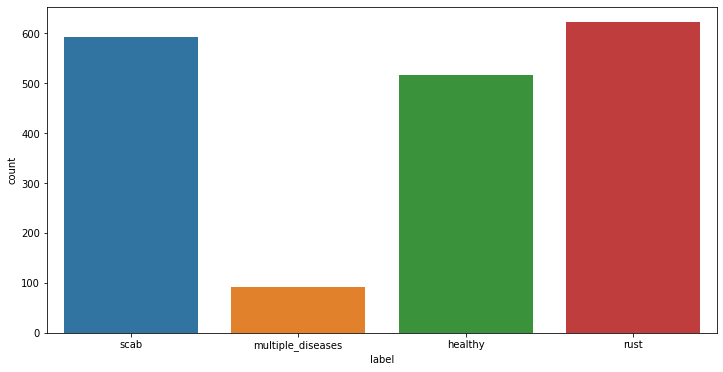

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(x=y['label'])

From the bar chart, there are only a very small number of leaves with multiple diseases, causing class imbalance issue. 

To prevent our model from underfitting this category, we will need to perform oversampling on the training data to balance out the class labels.

### Looking at the RGB channels for the images

<AxesSubplot:ylabel='Count'>

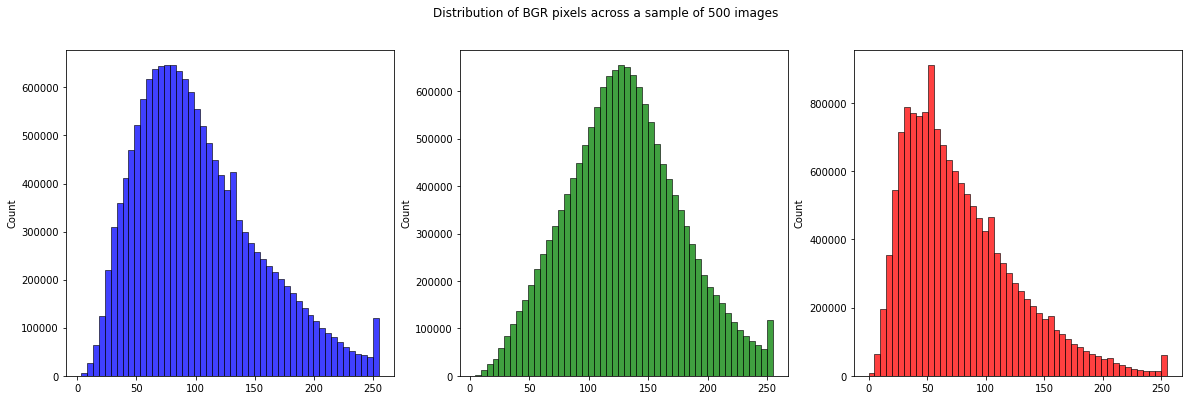

In [6]:
sample_images = y.image.iloc[0:500]

blue_pixels = np.array([])
for image in sample_images:
    blue_pixels = np.concatenate((blue_pixels, image[:, :, 0].flatten()))

green_pixels = np.array([])
for image in sample_images:
    green_pixels = np.concatenate((green_pixels, image[:, :, 1].flatten()))
    
red_pixels = np.array([])
for image in sample_images:
    red_pixels = np.concatenate((red_pixels, image[:, :, 2].flatten()))
    
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Distribution of BGR pixels across a sample of 500 images")
sns.histplot(blue_pixels, color='b', bins=50, ax=ax[0])
sns.histplot(green_pixels, color='g', bins=50, ax=ax[1])
sns.histplot(red_pixels, color='r', bins=50, ax=ax[2])

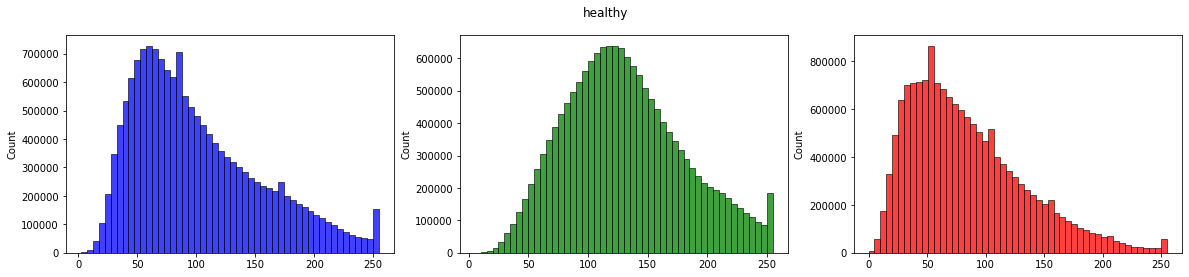

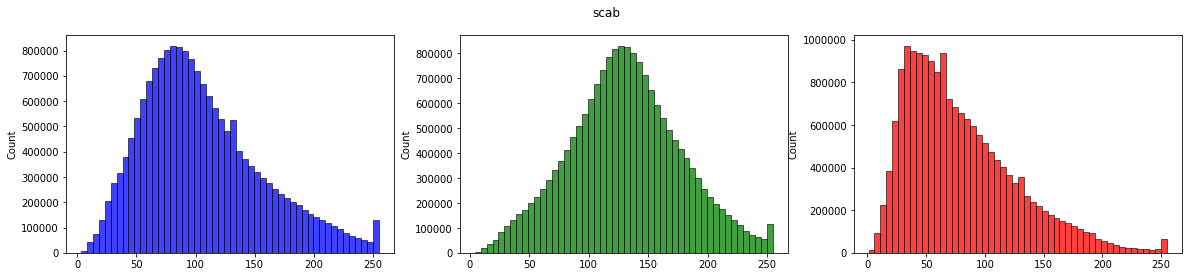

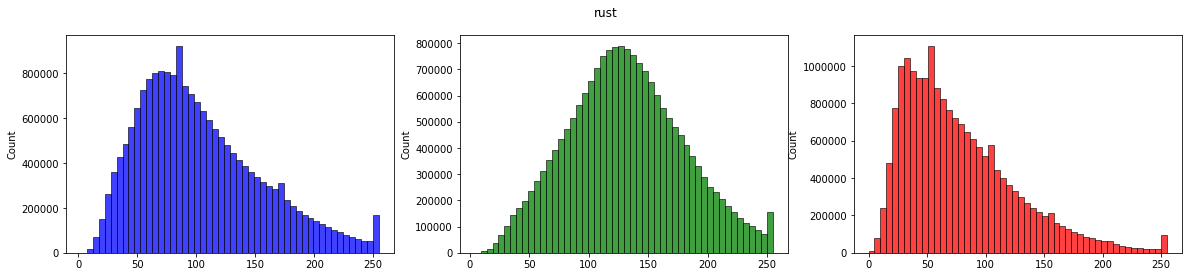

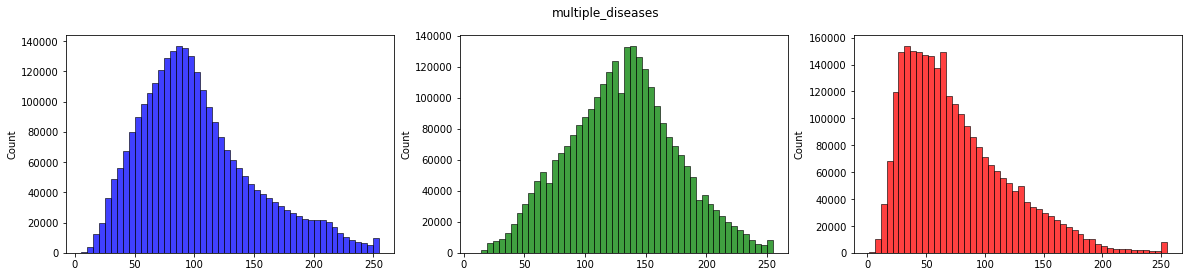

In [7]:
categories = ['healthy', 'scab', 'rust', 'multiple_diseases']

for category in categories:
    images = y[y.label == category].image

    blue_pixels = np.array([])
    for image in images:
        blue_pixels = np.concatenate((blue_pixels, image[:, :, 0].flatten()))

    green_pixels = np.array([])
    for image in images:
        green_pixels = np.concatenate((green_pixels, image[:, :, 1].flatten()))

    red_pixels = np.array([])
    for image in images:
        red_pixels = np.concatenate((red_pixels, image[:, :, 2].flatten()))

    fig, ax = plt.subplots(1, 3, figsize=(20, 4))
    fig.suptitle(category)
    sns.histplot(blue_pixels, color='b', bins=50, ax=ax[0])
    sns.histplot(green_pixels, color='g', bins=50, ax=ax[1])
    sns.histplot(red_pixels, color='r', bins=50, ax=ax[2])
    ax[0].ticklabel_format(axis='y', style='plain')
    ax[1].ticklabel_format(axis='y', style='plain')
    ax[2].ticklabel_format(axis='y', style='plain')
    plt.show()

Based on the graphs, the leaf images consist of mainly green and blue colours as expected, but less red colour as the bell of the curve is on the left.

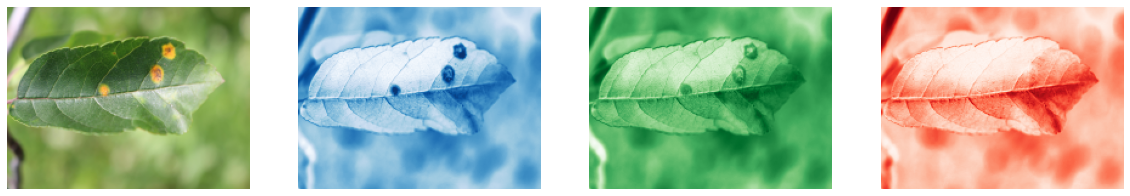

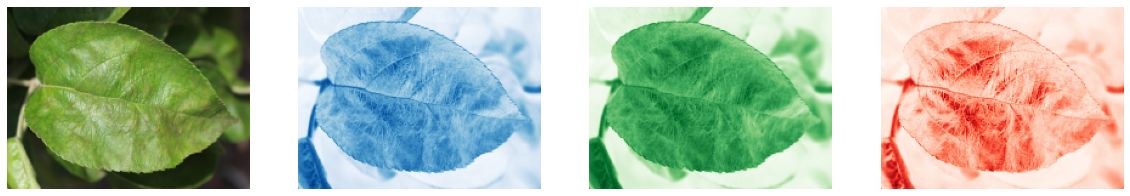

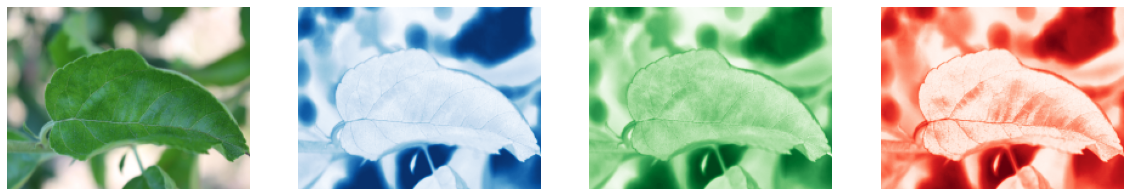

In [8]:
for i in [3,8,2]:
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(y.image[i])
    ax[0].set_axis_off()
    ax[1].imshow(y.image[i][:, :, 0], cmap='Blues')
    ax[1].set_axis_off()
    ax[2].imshow(y.image[i][:, :, 1], cmap='Greens')
    ax[2].set_axis_off()
    ax[3].imshow(y.image[i][:, :, 2], cmap='Reds')
    ax[3].set_axis_off()

According to the above image, our model might be able to learn to identify rust diseases by picking up the dots in the blue and green channels but not the red channel.

### Applying filters from OpenCV to spot common features of each disease

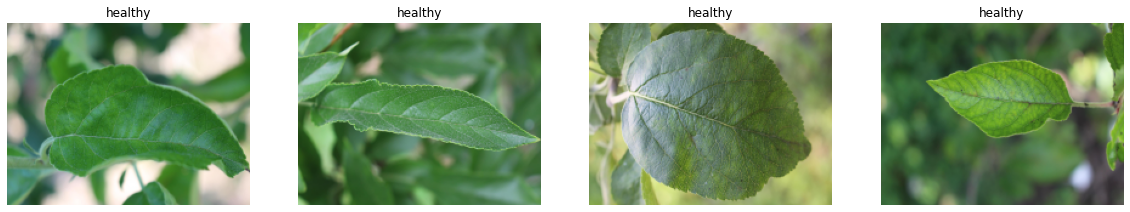

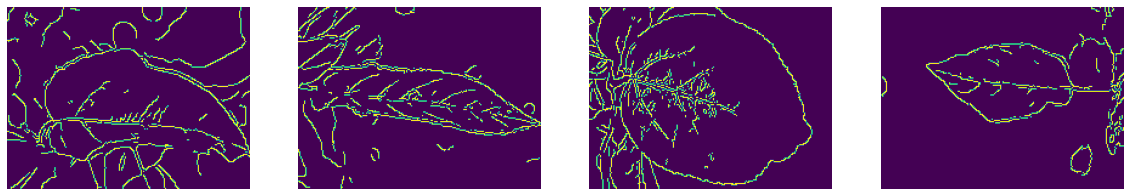

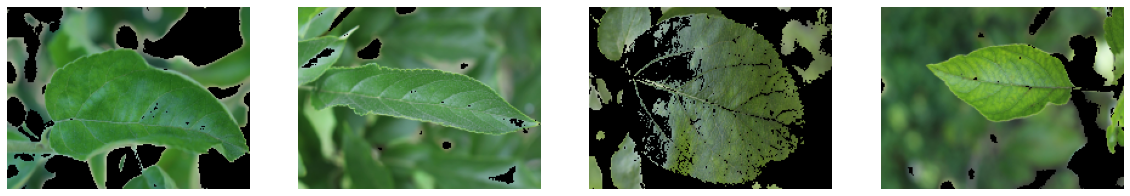

In [9]:
df = y[y.label == 'healthy'].reset_index()

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(df.loc[i, 'image'])
    ax[i].set_title(df.loc[i, 'label'])

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(cv2.Canny(df.loc[i, 'image'], img_width, img_height))
    
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    image = df.loc[i, 'image']
    hsv = cv2.cvtColor(df.loc[i, 'image'], cv2.COLOR_BGR2HSV)

    lower = np.array([40,25,25])
    upper = np.array([80,255,255])

    mask = cv2.inRange(hsv, lower, upper)
    image_result = cv2.bitwise_and(image, image, mask=mask)
    
    ax[i].set_axis_off()
    ax[i].imshow(image_result)

#### Healthy Leaves (above)

Healthy leaves are generally very green, all over the leaf.

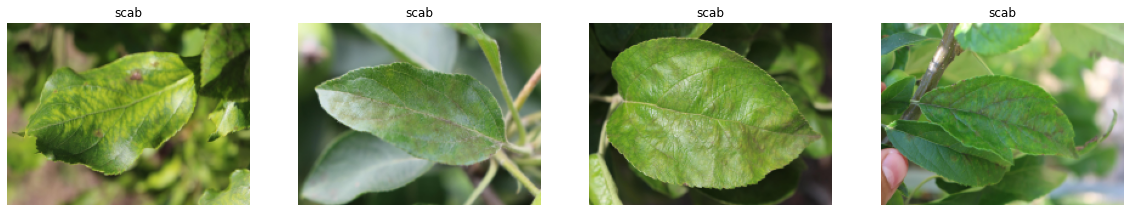

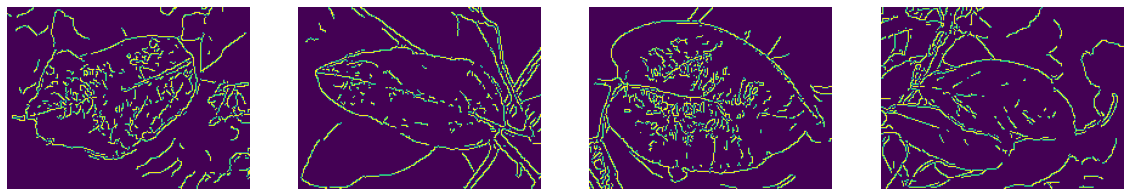

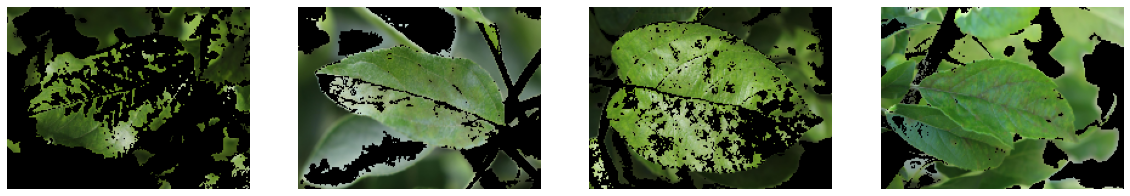

In [10]:
df = y[y.label == 'scab'].reset_index()

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(df.loc[i, 'image'])
    ax[i].set_title(df.loc[i, 'label'])
    
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(cv2.Canny(df.loc[i, 'image'], img_width, img_height))

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    image = df.loc[i, 'image']
    hsv = cv2.cvtColor(df.loc[i, 'image'], cv2.COLOR_BGR2HSV)

    lower = np.array([40,25,25])
    upper = np.array([80,255,255])

    mask = cv2.inRange(hsv, lower, upper)
    image_result = cv2.bitwise_and(image, image, mask=mask)
    
    ax[i].set_axis_off()
    ax[i].imshow(image_result)

#### Leaves with Scab disease (above)

Leaves with scab disease tend to have a lot of brown-ish markings and wrinkles.

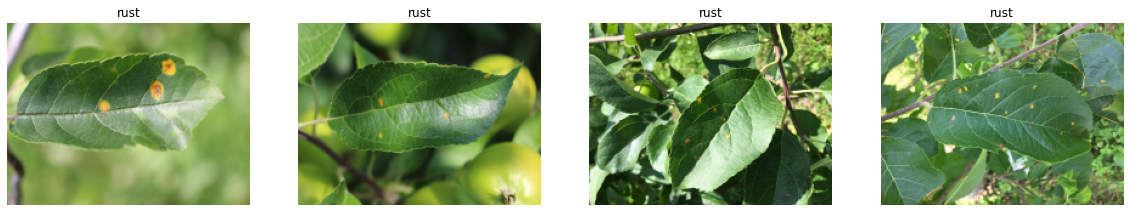

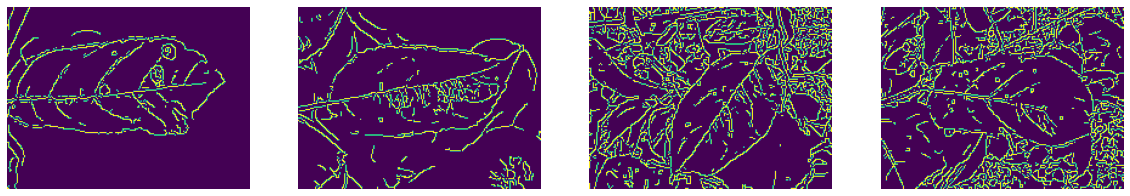

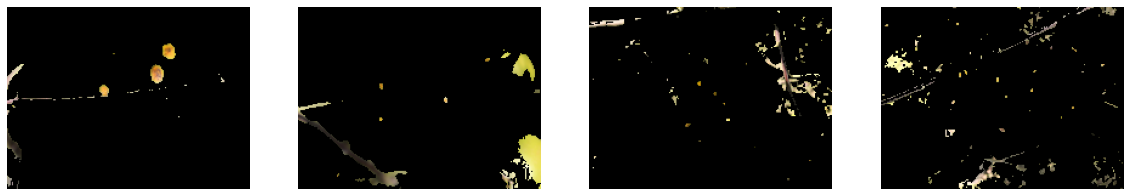

In [11]:
df = y[y.label == 'rust'].reset_index()

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(df.loc[i, 'image'])
    ax[i].set_title(df.loc[i, 'label'])
    
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(cv2.Canny(df.loc[i, 'image'], img_width, img_height))
    
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    image = df.loc[i, 'image']
    hsv = cv2.cvtColor(df.loc[i, 'image'], cv2.COLOR_BGR2HSV)
    
    lower = np.array([90,25,25])
    upper = np.array([130,255,255])

    mask = cv2.inRange(hsv, lower, upper)
    image_result = cv2.bitwise_and(image, image, mask=mask)
    
    ax[i].set_axis_off()
    ax[i].imshow(image_result)

#### Leaves with Rust disease (above)

Rust disease seems to be the easiest to identify by eye, as you're looking for yellow/brown spots on the leaf.

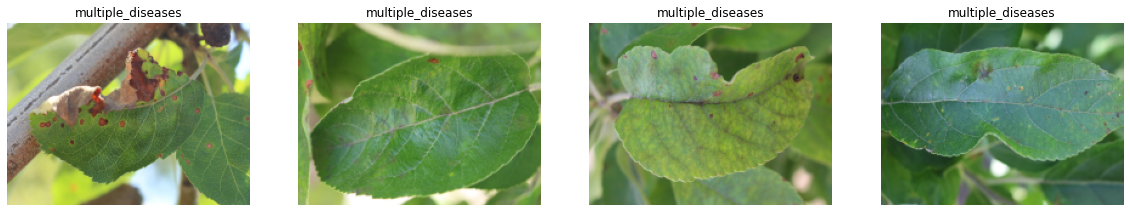

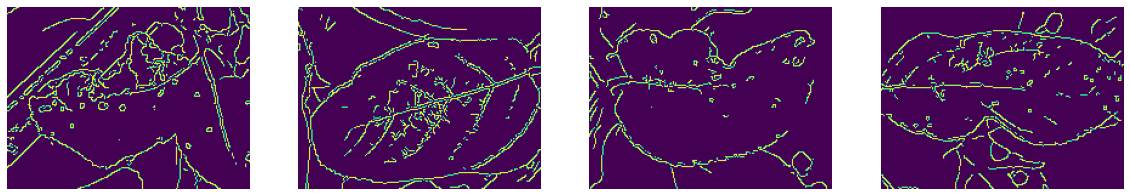

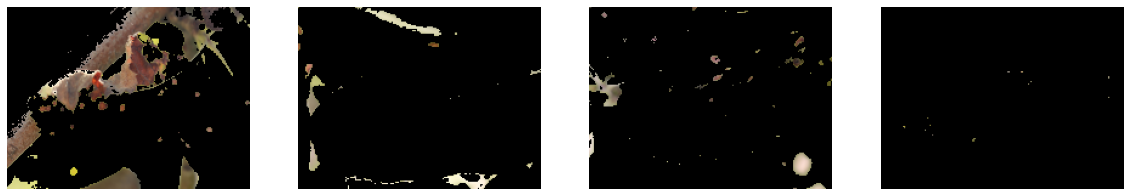

In [12]:
df = y[y.label == 'multiple_diseases'].reset_index()

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(df.loc[i, 'image'])
    ax[i].set_title(df.loc[i, 'label'])
    
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(cv2.Canny(df.loc[i, 'image'], img_width, img_height))
    
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    image = df.loc[i, 'image']
    hsv = cv2.cvtColor(df.loc[i, 'image'], cv2.COLOR_BGR2HSV)
    # blue
    lower = np.array([90,25,25])
    upper = np.array([130,255,255])

    mask = cv2.inRange(hsv, lower, upper)
    image_result = cv2.bitwise_and(image, image, mask=mask)
    
    ax[i].set_axis_off()
    ax[i].imshow(image_result)

#### Leaves with Multiple diseases (above)

Leaves with multiple diseases have a combination of yellow/brown spots, as well as brown scab markings.